# Running an agent on Grid2Op

In [34]:

from grid2op.Agent import RandomAgent
from grid2op.Converter.IdToAct import IdToAct

from grid2op import make
from grid2op.Action.PlayableAction import PlayableAction
from grid2op.Parameters import Parameters
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv
import re
import numpy as np
from grid2op.multi_agent.multi_agentExceptions import *

try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
    print("Using lightsim2grid!")
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

from grid2op.PlotGrid import PlotMatplot


action_domains = {
    'agent_0' : [0,1,2,3, 4],
    'agent_1' : [5,6,7,8,9,10,11,12,13]
}
env_name = "l2rpn_case14_sandbox"#"educ_case14_storage"
env = make(env_name, test=True, backend=bk_cls(),
                action_class=PlayableAction, _add_to_name="_test_ma", )


ma_env = MultiAgentEnv(env, action_domains, copy_env=True)

ma_env.seed(0)
obs = ma_env.reset()

global_random = RandomAgent(env.action_space)
print("GLOBAL RANDOM AGENT MADE")

agents = {}
for agent_nm in action_domains:
    IdToActThis = ma_env.action_spaces[agent_nm].make_local(IdToAct)
    assert IdToActThis.agent_name == agent_nm
    agents[agent_nm] = RandomAgent(ma_env.action_spaces[agent_nm],
                                   action_space_converter=IdToActThis
                                   )
    print(f"created agent {agent_nm}")

print("Agents created")
for seed_, ag in enumerate(sorted(agents.keys())):
    agents[ag].seed(seed_)

for agent_nm in action_domains:
    print(agents[agent_nm].act(None, None, None))
        

Using lightsim2grid!


/home/najarfar/Internship/Grid2Op/grid2op/MakeEnv/Make.py:394: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:123: UserWarning: Rules can not be changed in this version.
  warnings.warn("Rules can not be changed in this version.")
Exception ignored in: <function BaseEnv.__del__ at 0x7ff37733f430>
Traceback (most recent call last):
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/BaseEnv.py", line 3574, in __del__
    self.close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/BaseEnv.py", line 3074, in close
    self.observation_space.close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Observation/observationSpace.py", line 397, in close
    self.obs_env.close

GLOBAL RANDOM AGENT MADE
created agent agent_0
created agent agent_1
Agents created
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element(s):
	 	 - Switch bus of line (origin) id 6 [on substation 3]
	 	 - Switch bus of interco (or) id 0 [on substation 3]
	 	 - Switch bus of interco (or) id 1 [on substation 3]
	 - NOT force any particular bus configuration
	 - NOT change the status of any interconnections
	 - NOT force the status of any interconnections
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force reconnection of 1 powerlines ([6])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following eleme

## Grid plot

In [ ]:
converter = ma_env.action_spaces['agent_0'].make_local(IdToAct)(
    ma_env.action_spaces['agent_0']
)
converter.init_converter(
    change_line_status = False,
    storage = False
)

In [ ]:
converter = IdToAct(
        env.action_space
)
converter.init_converter(
    change_line_status = False,
    storage = False
)
print(converter.n)

521


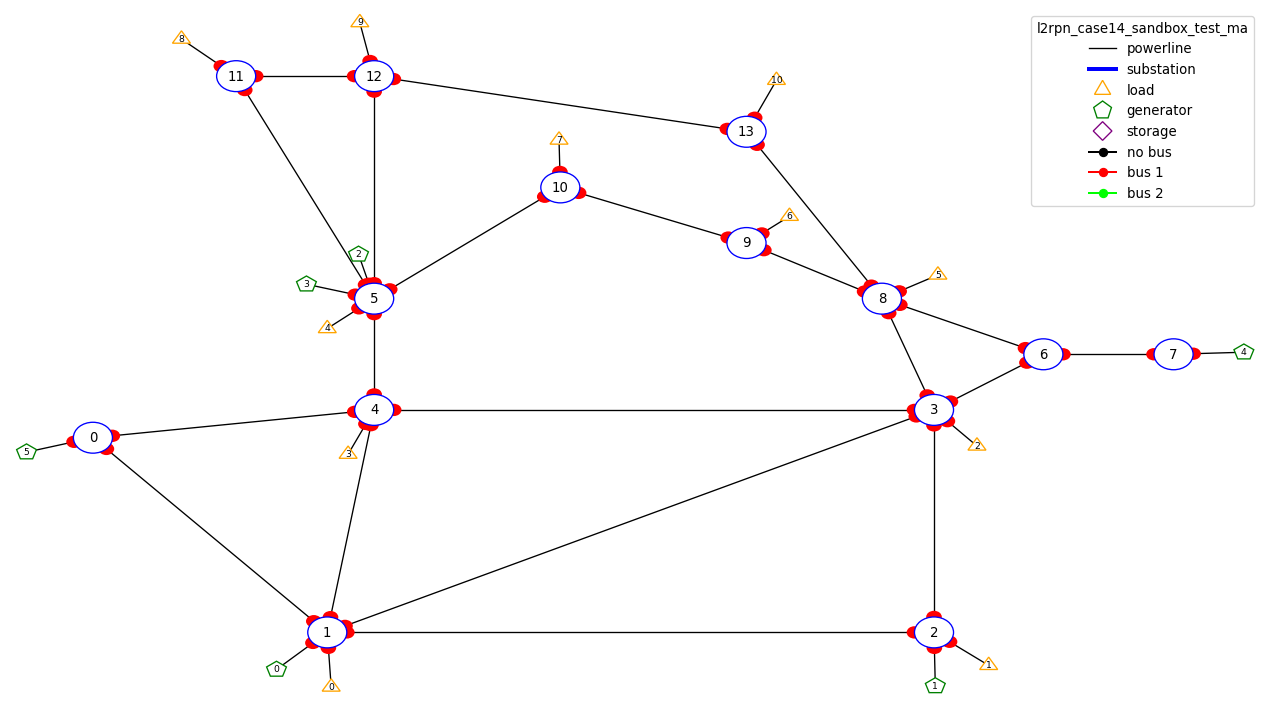

In [ ]:
plot_helper = PlotMatplot(env.observation_space)
line_ids = [int(i) for i in range(env.n_line)]
fig = plot_helper.plot_layout()

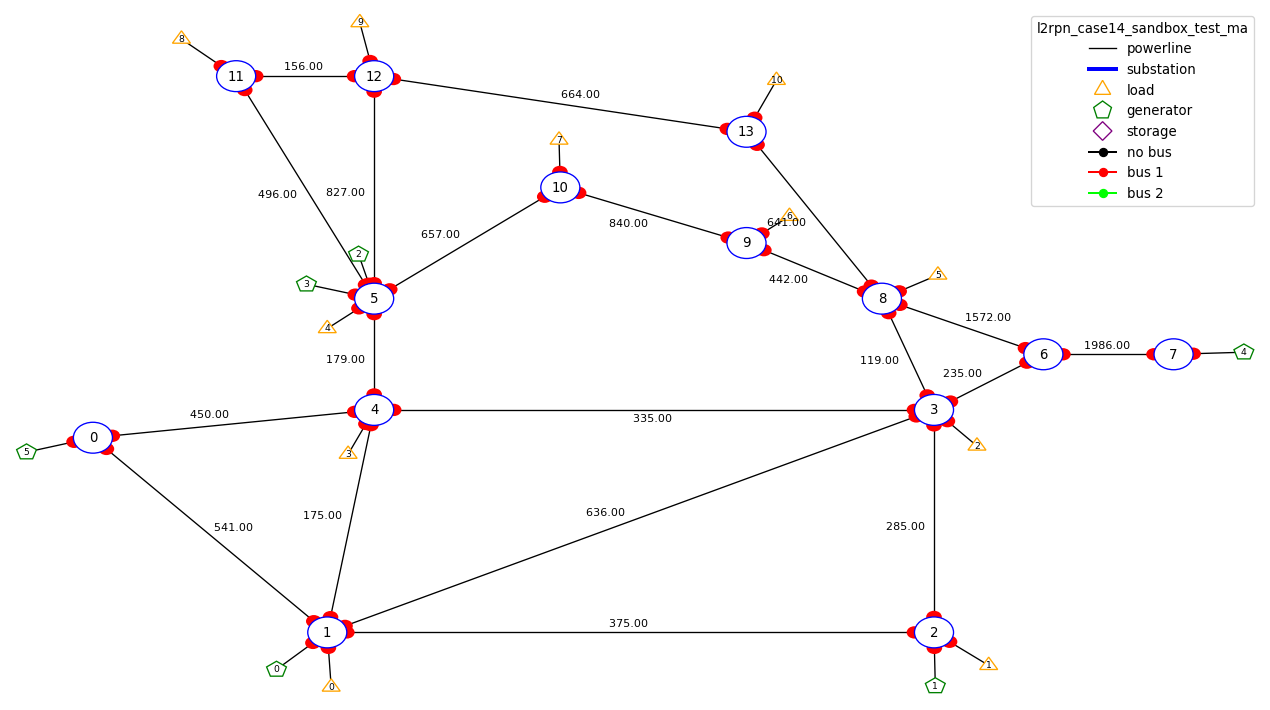

In [ ]:
fig = plot_helper.plot_info(line_values=env.get_thermal_limit())

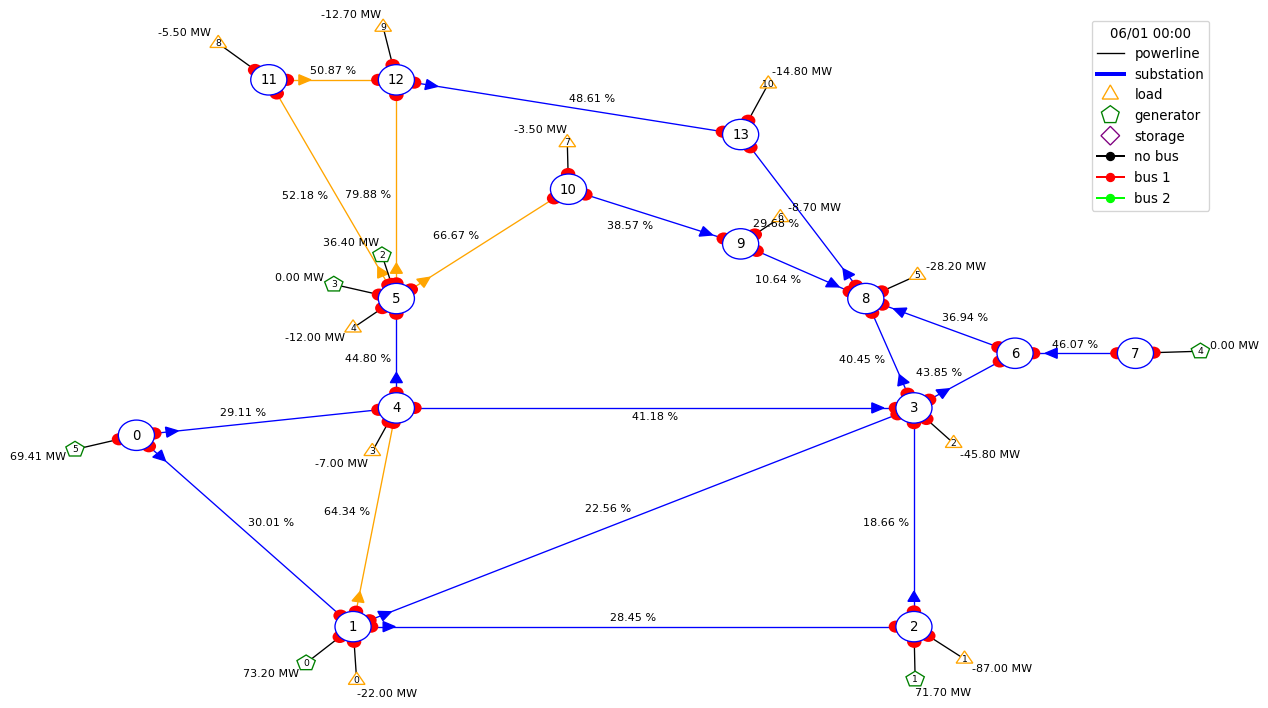

In [ ]:
obs = ma_env.reset()
fig_obs = plot_helper.plot_obs(obs['agent_0'], )

/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:123: UserWarning: Rules can not be changed in this version.
  warnings.warn("Rules can not be changed in this version.")
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:129: UserWarning: The central env has been heavily modified (parameters and reset) !
  warnings.warn("The central env has been heavily modified (parameters and reset) !")


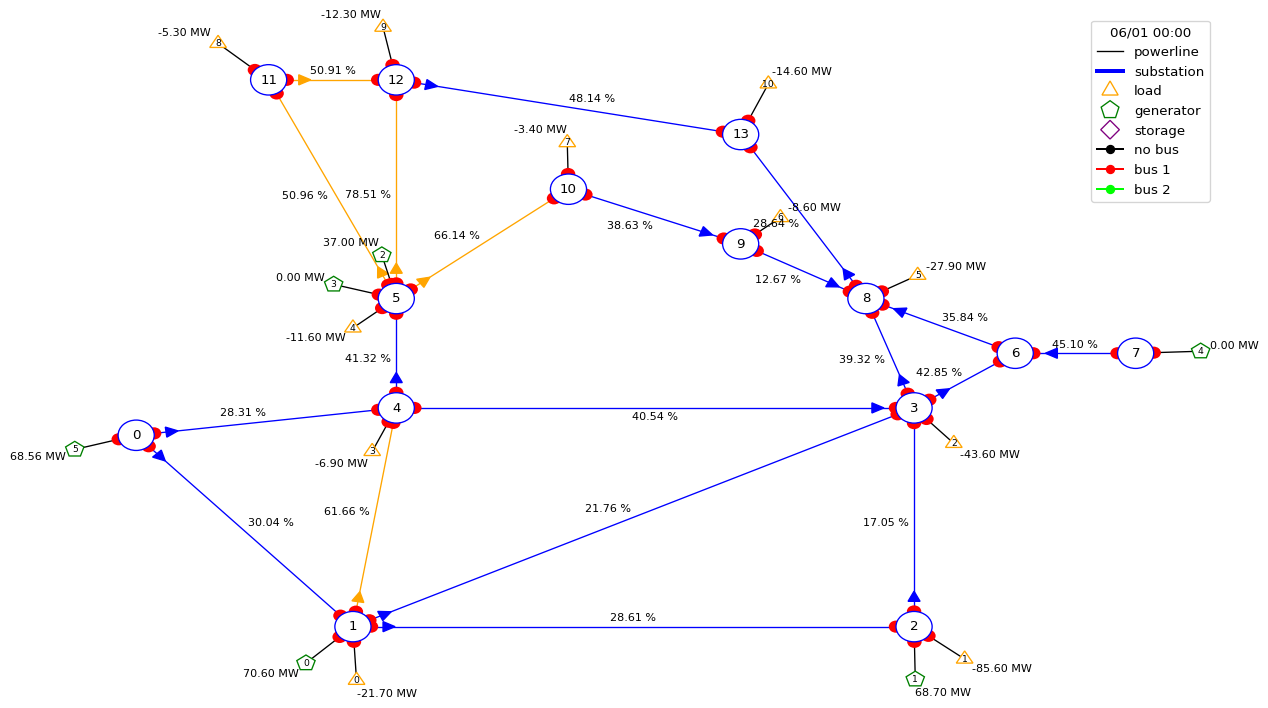

In [37]:
observation_domains = action_domains.copy()
ma_env = MultiAgentEnv(env, action_domains, observation_domains, copy_env=False)
plot_helper = PlotMatplot(ma_env.observation_spaces['agent_0'])

ma_env.seed(0)
obs = ma_env.reset()
    
fig_obs = plot_helper.plot_obs(obs['agent_0'])

In [ ]:
ma_env.action_spaces['agent_1'].name_line

array(['5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '6_7_18', '6_8_19'], dtype='<U8')

## Agents

In [ ]:
from grid2op.Agent import BaseAgent, DoNothingAgent
from grid2op.Observation import BaseObservation

class Expert(BaseAgent):
    def __init__(self,
                 action_space,
                 gridName="IEEE118",
                 **kwargs):
        super().__init__(action_space)
        self.grid = gridName  # IEEE14,IEEE118_R2 (WCCI or Neurips Track Robustness), IEEE118
        self.lines_disconnected = set()
        self.action_space = action_space
        self.threshold_powerFlow_safe = 0.95
        self.maxOverloadsAtATime = 3  # We should not run it more than
        #self.config = {
        #    "totalnumberofsimulatedtopos": 25,
        #    "numberofsimulatedtopospernode": 5,
        #    "maxUnusedLines": 2,
        #    "ratioToReconsiderFlowDirection": 0.75,
        #    "ratioToKeepLoop": 0.25,
        #    "ThersholdMinPowerOfLoop": 0.1,
        #    "ThresholdReportOfLine": 0.2
        #}
        self.curr_iter = 0
        
    def act(self, observation : BaseObservation, reward, done = False):
        self.curr_iter += 1

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTestedOverloads = 0
        overloaded = np.any(observation.rho >= 1)
        
        if overloaded == 0:
            return self.action_space({})
        else:
            best_action = self.action_space({})
            best_reward = -999
            for l in range(self.action_space.n_line):
                action = self.action_space({"change_line_status": l})
                _, _reward, _done, _ = observation.simulate(action, time_step=1)
                if _reward > best_reward and not _done:
                    best_action = action.copy()
                    #print("best action updated")
            
            return best_action
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass

    
class Expert2(BaseAgent):
    def __init__(self,
                 action_space,
                 gridName="IEEE118",
                 **kwargs):
        """This agent is suited only for l2rpn_case14_sandbox !"
        """
        super().__init__(action_space)
        self.grid = gridName  # IEEE14,IEEE118_R2 (WCCI or Neurips Track Robustness), IEEE118
        self.lines_disconnected = set()
        self.action_space = action_space
        self.threshold_powerFlow_safe = 0.95
        self.maxOverloadsAtATime = 3  # We should not run it more than
        
        self.curr_iter = 0
        
    def act(self, observation : BaseObservation, reward, done = False):
        self.curr_iter += 1

        overloaded = np.any(observation.rho >= self.threshold_powerFlow_safe)
        
        if not overloaded:
            return self.action_space({})
        else:
            if observation.line_status[12]:
                return self.action_space({"change_line_status": 12})
            
            return self.action_space({"change_line_status": 14})
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass
    
class Expert3(BaseAgent):
    def __init__(self,
                 action_space,
                 gridName="IEEE118",
                 **kwargs):
        """This agent is suited only for l2rpn_case14_sandbox !"
        """
        super().__init__(action_space)
        self.grid = gridName  # IEEE14,IEEE118_R2 (WCCI or Neurips Track Robustness), IEEE118
        self.lines_disconnected = set()
        self.action_space = action_space
        self.threshold_powerFlow_safe = 0.95
        self.maxOverloadsAtATime = 3  # We should not run it more than
        #self.config = {
        #    "totalnumberofsimulatedtopos": 25,
        #    "numberofsimulatedtopospernode": 5,
        #    "maxUnusedLines": 2,
        #    "ratioToReconsiderFlowDirection": 0.75,
        #    "ratioToKeepLoop": 0.25,
        #    "ThersholdMinPowerOfLoop": 0.1,
        #    "ThresholdReportOfLine": 0.2
        #}
        print()
        self.topo_actions_todo = [
            #self.action_space({"curtail": [(2, .06)]}),
            self.action_space({"set_bus": (self.action_space.line_ex_pos_topo_vect[4], 2)}),
            self.action_space({"set_bus": (self.action_space.load_pos_topo_vect[3], 2)}),
            #self.action_space({"set_bus": (self.action_space.line_or_pos_topo_vect[8], 2)}),
            #self.action_space({"set_bus": (self.action_space.gen_pos_topo_vect[2], 2)}),
            self.action_space({"set_bus": (self.action_space.line_or_pos_topo_vect[19], 2)}),
            self.action_space({"set_bus": (self.action_space.load_pos_topo_vect[5], 2)}),
            self.action_space({"set_bus": (self.action_space.line_or_pos_topo_vect[10], 2)})
        ]
        
    def act(self, observation : BaseObservation, reward, done = False):

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTe
        overloaded = np.any(observation.rho >= 1)

        if len(self.topo_actions_todo):
            return self.topo_actions_todo.pop(0)
        elif not overloaded:
            return self.action_space({})
        else:
            if observation.line_status[12]:
                return self.action_space({"change_line_status": 12})
            
            return self.action_space({"change_line_status": 14})
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass

In [ ]:
class LocalExpert0(BaseAgent):
    def __init__(self,
                 action_space,
                 ma_env,
                 **kwargs):
        super().__init__(action_space)
        
        self.executed_actions = set()
        
        self.action_space = action_space
        
        self.curr_iter = 0
        self.ma_env = ma_env
        
        self.global_action_space = ma_env._cent_env.action_space
        
        self.actions_todo = [
            self.action_space({
                'set_bus' : [
                    (self.action_space.line_ex_pos_topo_vect[4], 2),
                    (self.action_space.line_ex_pos_topo_vect[6], 2)
                ]
            }).to_global(self.global_action_space)
        ]
        
    def act(self, observation : BaseObservation, reward, done = False):
        self.curr_iter += 1

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTestedOverloads = 0
        overloaded = np.any(observation.rho >= 1)
        
        if overloaded == 0:
            return self.action_space({})
        else:
            best_action = self.action_space({})
            best_reward = -999
            other_action = ...
            
            for l in range(self.action_space.n_line):
                action = self.action_space({"change_line_status": l})
                global_action = self.ma_env._local_action_to_global(action)
                all_action = other_action + global_action
                _, _reward, _done, _ = observation.simulate(all_action, time_step=1)
                if _reward > best_reward and not _done:
                    best_action = action.copy()
                    #print("best action updated")
            
            return best_action
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass

/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:124: UserWarning: Rules can not be changed in this version.
  warnings.warn("Rules can not be changed in this version.")
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:130: UserWarning: The central env has been reset !
  warnings.warn("The central env has been reset !")


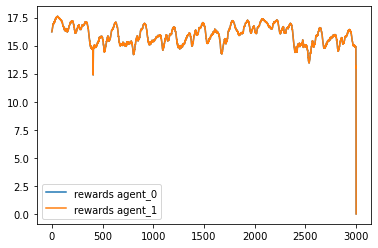

In [ ]:
import copy
import numpy as np
import shutil
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from grid2op.Reward import L2RPNReward
from grid2op.Runner import Runner
path_agents = "study_agent_getting_started"
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
action_domains = {
    'agent_0' : [0,1,2,3, 4],
    'agent_1' : [5,6,7,8,9,10,11,12,13]
}

from grid2op.Agent import BaseAgent, DoNothingAgent
from grid2op.Observation import BaseObservation


        
    
env_name = "l2rpn_case14_sandbox"
env = make(env_name, test=False, backend=bk_cls(),reward_class=L2RPNReward,
                action_class=PlayableAction, _add_to_name="_test_ma")


ma_env = MultiAgentEnv(env, action_domains, copy_env=False)
ma_env.seed(0)

actors = dict()
actors['agent_0'] = DoNothingAgent(ma_env.action_spaces['agent_0'])
actors['agent_1'] = LocalExpert(ma_env.action_spaces['agent_1'], ma_env)



## API

In [17]:
from typing import Dict
from grid2op.multi_agent.ma_typing import MAAgents
from grid2op.Environment.BaseEnv import BaseEnv
from grid2op.Agent.baseAgent import BaseAgent
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv


def _run_simple_actor(
    env : BaseEnv,
    actor : BaseAgent,
    nb_episodes : int,
) -> dict:
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = env.reset()
    t = 0
    
    rewards_history = []
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    obs_history = [[] for _ in range(nb_episodes)]
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    reward = 0
    
    for episode in range(nb_episodes):
        while True:
            t += 1
            action = actor.act(observation = obs, reward = reward)
            obs, reward, done, info = env.step(action)

            rewards_history.append(reward)
            info_history[episode].append(info.copy())
            obs_history[episode].append(obs.copy())
            done_history[episode].append(done)
            actions_history[episode].append(action.copy())
            

            if done:
                mean_rewards_history[episode] = np.mean(rewards_history)
                std_rewards_history[episode] = np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history)
                obs = env.reset()
                T[episode] = t
                t = 0
                break
            
    return {
        'mean_rewards' : mean_rewards_history,
        'std_rewards' : std_rewards_history,
        'episode_len' : T,
        'info_history' : info_history,
        'obs_history' : obs_history,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
         
        # TODO cum reward done
        # TODO local actions
    }

def _run_ma_actors(
    ma_env : MultiAgentEnv,
    actors : MAAgents,
    nb_episodes : int,
) -> dict:
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = ma_env.reset()
    t = 0
    
    rewards_history = []
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    #obs_history = [[] for _ in range(nb_episodes)]
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    r = 0
    
    for episode in range(nb_episodes):
        while True:
            t += 1
            actions = {
                agent : actors[agent].act(observation = obs[agent], reward = r)
                for agent in ma_env.agents
            }
            obs, reward, dones, info = ma_env.step(actions)

            r = reward[ma_env.agents[0]]
            rewards_history.append(r)
            info_history[episode].append(info[ma_env.agents[0]].copy())
            #obs_history[episode].append(obs[ma_env.agents[0]].copy())
            done_history[episode].append(dones[ma_env.agents[0]])
            actions_history[episode].append(ma_env.global_action.copy())
                

            if dones[ma_env.agents[0]]:
                mean_rewards_history[episode] = np.mean(rewards_history)
                std_rewards_history[episode] =  np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history)
                
                obs = ma_env.reset()
                T[episode] = t
                t = 0
                break
            
    return {
        'mean_rewards' : mean_rewards_history,
        'std_rewards' : std_rewards_history,
        'episode_len' : T,
        'info_history' : info_history,
        #'obs_history' : obs_history,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
    }

    


In [25]:
def compare_simple_and_multi(
    ma_env : BaseEnv, # It is grid2op.multi_agent.multiAgentEnv.MultiAgentEnv
    simple_actor : BaseAgent, 
    ma_actors : MAAgents, 
    episodes : int = 2,
    seed = 0,
    chronics_id = 0,
    save_path = "./"
    ):
    
    #ma_env = MultiAgentEnv(env, action_domains, copy_env=False)
    
    ma_env.seed(seed)
    ma_env._cent_env.set_id(chronics_id)
    
    results_simple = _run_simple_actor(ma_env._cent_env, simple_actor, episodes)
    results_ma = _run_ma_actors(ma_env, ma_actors, episodes)
    
    #save results
    # TODO
    
    return results_simple, results_ma

## Do nothing

In [ ]:
from grid2op.Agent.doNothing import DoNothingAgent
simple_actor = DoNothingAgent(ma_env._cent_env.action_space)
ma_actors = {
    agent : DoNothingAgent(ma_env.action_spaces[agent])
    for agent in ma_env.agents
}
results_simple, results_ma = compare_simple_and_multi(
    ma_env=ma_env,
    simple_actor=simple_actor,
    ma_actors=ma_actors
)

In [ ]:
results_simple['mean_rewards'] - np.array([66.48664093, 65.62093353])

array([1.75788273e-10, 2.71484168e-09])

In [ ]:
assert np.linalg.norm(results_simple['mean_rewards'] - np.array([66.48664093, 65.62093353])) < 1e-8
assert (results_simple['mean_rewards'] == results_ma["mean_rewards"]).all() #TODO mettre les vraies valeurs done

assert np.linalg.norm(results_simple['std_rewards'] - np.array([4.64013243, 5.17563963])) < 1e-8
assert (results_simple['std_rewards'] == results_ma["std_rewards"]).all()

assert (results_simple['episode_len'] == np.array([575, 575])).all()
assert (results_simple['episode_len'] == results_ma["episode_len"]).all()

## Disconnect overloaded

In [26]:
from grid2op.Observation.baseObservation import BaseObservation

class Disconnector(BaseAgent):
    def __init__(self,
                 action_space,
                 is_local = False,
                 threshold_powerFlow_safe = 1.,
                 **kwargs):
        super().__init__(action_space)
        self.lines_disconnected = set()
        self.action_space = action_space
        self.threshold_powerFlow_safe = threshold_powerFlow_safe
        self.is_local = is_local

        
    def act(self, observation : BaseObservation, reward, done = False):

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTestedOverloads = 0
        overloaded = (observation.rho >= self.threshold_powerFlow_safe)
        
        if not np.any(overloaded):
            return self.action_space({})
        else:
            action = self.action_space({})
            
            overloaded_lines = np.where(overloaded)[0]
            
            for lineid in overloaded_lines:
                if self.is_local:
                    if self.action_space.mask_line[lineid]:#TODO use a mask done
                        local_id = np.where(self.action_space.line_orig_ids == lineid)[0][0]
                        action.set_line_status = [(local_id, -1)]
                        #print(action, 'ma')
                        break
                else:
                    action.set_line_status = [(lineid, -1)]
                    #print(action, 'simple')
                    break
                
            return action
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass
    
    

In [27]:
simple_actor = Disconnector(ma_env._cent_env.action_space, threshold_powerFlow_safe=0.9)
ma_actors = {
    agent : Disconnector(ma_env.action_spaces[agent], is_local=True, threshold_powerFlow_safe=0.9)
    for agent in ma_env.agents
}
results_simple, results_ma = compare_simple_and_multi(
    ma_env=ma_env,
    simple_actor=simple_actor,
    ma_actors=ma_actors,
    episodes=2
)

In [28]:
print(results_ma['mean_rewards'])

[66.81484985 66.80235291]


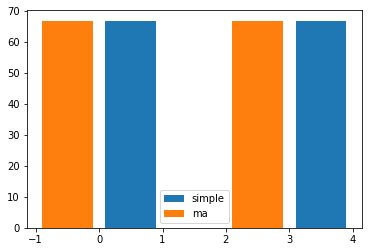

In [29]:
import matplotlib.pyplot as plt
plt.bar(np.array([0,3])+0.5,results_simple['mean_rewards'], label = 'simple')
plt.bar(np.array([0,3])-0.5,results_ma['mean_rewards'], label = 'ma')
plt.legend()
plt.show()

## Replay with 2 random agents

In [ ]:
from grid2op.Agent import RandomAgent
simple_actor = RandomAgent(env.action_space)

ma_actors = dict()
for agent_nm in ma_env.agents:
    IdToActThis = ma_env.action_spaces[agent_nm].make_local(IdToAct)
    assert IdToActThis.agent_name == agent_nm    
    ma_actors[agent_nm] = RandomAgent(ma_env.action_spaces[agent_nm],
                                   action_space_converter=IdToActThis
                                   )


results_simple, results_ma = compare_simple_and_multi(
    env=env,
    simple_actor=simple_actor,
    ma_actors=ma_actors,
    # TODO plus d'episodes
)

Exception ignored in: <function BaseEnv.__del__ at 0x7fe125a35af0>
Traceback (most recent call last):
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/BaseEnv.py", line 3574, in __del__
    self.close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/BaseEnv.py", line 3074, in close
    self.observation_space.close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Observation/observationSpace.py", line 397, in close
    self.obs_env.close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/_ObsEnv.py", line 671, in close
    super().close()
  File "/home/najarfar/Internship/Grid2Op/grid2op/Environment/BaseEnv.py", line 3058, in close
    raise EnvError(
grid2op.Exceptions.EnvExceptions.EnvError: Grid2OpException EnvError "This environment is closed already, you cannot close it a second time."
Exception ignored in: <function BaseEnv.__del__ at 0x7fe125a35af0>
Traceback (most recent call last):
  File "/home/najarfar/Internship/Grid2Op/grid2op/Env

In [ ]:
print(len(results_ma['actions'][0]))

3


In [ ]:
from grid2op.Agent.fromActionsListAgent import FromActionsListAgent

for action in results_ma['actions'][0]:
    print(action)

# Faire plusieurs replay sur plusieurs episodes
replay = FromActionsListAgent(
    env.action_space,
    results_ma['actions'][0]
)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element(s):
	 	 - Switch bus of generator id 1 [on substation 2]
	 - Set the bus of the following element(s):
	 	 - Assign bus 2 to line (origin) id 10 [on substation 8]
	 	 - Assign bus 1 to line (origin) id 11 [on substation 8]
	 	 - Assign bus 2 to line (extremity) id 16 [on substation 8]
	 	 - Assign bus 2 to line (origin) id 19 [on substation 8]
	 	 - Assign bus 1 to load id 5 [on substation 8]


In [ ]:
from grid2op.Runner import Runner
import os 
import shutil
from tqdm.notebook import tqdm

env = ma_env._cent_env 

#env = make("l2rpn_case14_sandbox", test = True, backend = bk_cls())

replay = FromActionsListAgent(
    env.action_space,
    results_ma['actions'][0]
)

path_agents = "study_agent_getting_started"
max_iter = 10_000

shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "ReplayAgent")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

env.seed(0)
env.set_id(0)
env.reset()

runner = Runner(**env.get_params_for_runner(),
                agentClass=None,
                agentInstance=replay
                )
res = runner.run(path_save=path_agent,
                 nb_episode=1, 
                 max_iter=max_iter,
                 nb_process=2,
                 pbar=tqdm)
print("The results for the evaluated agent are:")
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the evaluated agent are:
	For chronics with id 0000
		 - cumulative reward: -10.000000
		 - number of time steps completed: 1 / 575


In [ ]:
print(results_ma['cumulative_reward'])

[-10.        238.1716156]


# Trash

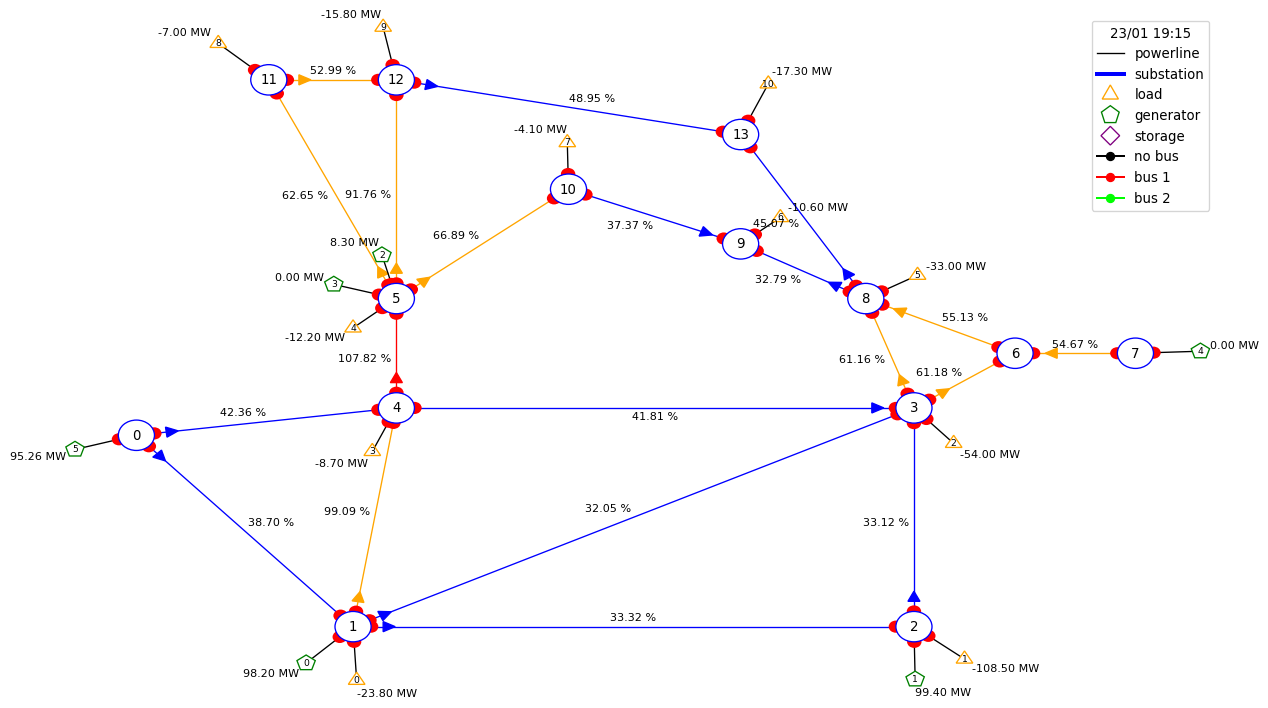

In [ ]:
from grid2op.Episode import EpisodeData
from grid2op.PlotGrid import PlotMatplot

episode_studied = EpisodeData.list_episode(path_agent)
this_episode = EpisodeData.from_disk(*episode_studied[0])
obs = copy.deepcopy(this_episode.observations[-2])
# and change the topology (just to have something to represent)
#obs.topo_vect[3:9] = [2,2,1,1,2,1]

plot_helper = PlotMatplot(observation_space=this_episode.observation_space)
fig = plot_helper.plot_obs(obs)

## Preparing the env

In [ ]:
# gym specific, we simply do a copy paste of what we did in the previous cells, wrapping it in the
# MyEnv class, and train a Proximal Policy Optimisation based agent
import gym
import ray
import numpy as np
from grid2op.gym_compat import ContinuousToDiscreteConverter
from grid2op.gym_compat import MultiToTupleConverter
      
class MyEnv(gym.Env):
    def __init__(self, env_config):
        import grid2op
        from grid2op.gym_compat import GymEnv
        from grid2op.gym_compat import ScalerAttrConverter, ContinuousToDiscreteConverter, MultiToTupleConverter

        # 1. create the grid2op environment
        if not "env_name" in env_config:
            raise RuntimeError("The configuration for RLLIB should provide the env name")
        nm_env = env_config["env_name"]
        del env_config["env_name"]
        self.env_glop = grid2op.make(nm_env, **env_config)

        # 2. create the gym environment
        self.env_gym = GymEnv(self.env_glop)
        obs_gym = self.env_gym.reset()

        # 3. (optional) customize it (see section above for more information)
        ## customize action space
        self.env_gym.action_space = self.env_gym.action_space.ignore_attr("set_bus").ignore_attr("set_line_status")
        self.env_gym.action_space = self.env_gym.action_space.reencode_space("redispatch",
                                                                             ContinuousToDiscreteConverter(nb_bins=11)
                                                                             )
        self.env_gym.action_space = self.env_gym.action_space.reencode_space("change_bus", MultiToTupleConverter())
        self.env_gym.action_space = self.env_gym.action_space.reencode_space("change_line_status",
                                                                             MultiToTupleConverter())
        self.env_gym.action_space = self.env_gym.action_space.reencode_space("redispatch", MultiToTupleConverter())
        ## customize observation space
        ob_space = self.env_gym.observation_space
        ob_space = ob_space.keep_only_attr(["rho", "gen_p", "load_p", "topo_vect", "actual_dispatch"])
        ob_space = ob_space.reencode_space("actual_dispatch",
                                           ScalerAttrConverter(substract=0.,
                                                               divide=self.env_glop.gen_pmax
                                                               )
                                           )
        ob_space = ob_space.reencode_space("gen_p",
                                           ScalerAttrConverter(substract=0.,
                                                               divide=self.env_glop.gen_pmax
                                                               )
                                           )
        ob_space = ob_space.reencode_space("load_p",
                                           ScalerAttrConverter(substract=obs_gym["load_p"],
                                                               divide=0.5 * obs_gym["load_p"]
                                                               )
                                           )
        self.env_gym.observation_space = ob_space

        # 4. specific to rllib
        self.action_space = self.env_gym.action_space
        self.observation_space = self.env_gym.observation_space
        
        # 4. bis: to avoid other type of issues, we recommend to build the action space and observation
        # space directly from the spaces class.
        d = {k: v for k, v in self.env_gym.observation_space.spaces.items()}
        self.observation_space = gym.spaces.Dict(d)
        a = {k: v for k, v in self.env_gym.action_space.items()}
        self.action_space = gym.spaces.Dict(a)

    def reset(self):
        obs = self.env_gym.reset()
        return obs

    def step(self, action):
        obs, reward, done, info = self.env_gym.step(action)
        return obs, reward, done, info

In [ ]:
env_config = {
    "env_name": "l2rpn_case14_sandbox",
    "test" : False,
    "backend" : bk_cls()     
}
env = MyEnv(env_config)
import ray.rllib.agents.sac as sac
from ray.tune.logger import pretty_print
from tqdm.notebook import tqdm

config = sac.DEFAULT_CONFIG.copy()
config["num_gpus"] = 0
config["num_workers"] = 2
config["env_config"] = env_config

try:
    trainer = sac.SACTrainer(config=config, env=MyEnv)

    for i in tqdm(range(1000)):
       # Perform one iteration of training the policy with PPO
       result = trainer.train()
       print(pretty_print(result))

       if i % 100 == 0:
           checkpoint = trainer.save()
           print("checkpoint saved at", checkpoint)
finally:
    ray.shutdown()

2022-05-30 19:34:13,555	WARNING sac.py:212 -- You need `tensorflow_probability` in order to run SAC! Install it via `pip install tensorflow_probability`. Your tf.__version__=2.4.1.Trying to import tfp results in the following error:


ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.6; Detected an installation of version 2.4.1. Please upgrade TensorFlow to proceed.

In [ ]:

env_gym.action_space = env_gym.action_space.reencode_space("redispatch",
                                                           ContinuousToDiscreteConverter(nb_bins=11)
                                                           )
env_gym.action_space = env_gym.action_space.reencode_space("redispatch", MultiToTupleConverter())
env_gym.action_space = env_gym.action_space.reencode_space("set_bus", MultiToTupleConverter())
env_gym.action_space = env_gym.action_space.reencode_space("set_line_status", MultiToTupleConverter())


In [ ]:
from grid2op.gym_compat import DiscreteActSpace
env_gym.action_space = DiscreteActSpace(env_gym.init_env.action_space)
print(f"There are {env_gym.action_space.n} independant actions")
# And now our action space looks like:
env_gym.action_space

In [ ]:
dim_obs_space = np.sum([np.sum(env_gym.observation_space[el].shape).astype(int) 
                        for el in env_gym.observation_space.spaces])
env_gym.observation_space = env_gym.observation_space.keep_only_attr(["rho", "gen_p", "load_p", "topo_vect", 
                                                                      "actual_dispatch"])
new_dim_obs_space = np.sum([np.sum(env_gym.observation_space[el].shape).astype(int) 
                        for el in env_gym.observation_space.spaces])
print(f"The new size of the observation space is : "
      f"{new_dim_obs_space} (it was {dim_obs_space} before!)")

In [ ]:
from grid2op.gym_compat import ScalerAttrConverter
from gym.spaces import Box
ob_space = env_gym.observation_space
ob_space = ob_space.reencode_space("actual_dispatch",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env_glop.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("gen_p",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env_glop.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("load_p",
                                  ScalerAttrConverter(substract=obs_gym["load_p"],
                                                      divide=0.5 * obs_gym["load_p"]
                                                      )
                                  )

# for even more customization, you can use any functions you want !
shape_ = (env_glop.dim_topo, env_glop.dim_topo)
ob_space.add_key("connectivity_matrix",
                                  lambda obs: obs.connectivity_matrix(),  # can be any function returning a gym space
                                  Box(shape=shape_,
                                      low=np.zeros(shape_),
                                      high=np.ones(shape_),
                                    )  # this "Box" should represent the return type of the above function
                                  )
env_gym.observation_space = ob_space
env_gym.observation_space

## Constructing the agent

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import clear_output
clear_output()

In [ ]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_layout()

In [ ]:
from grid2op.gym_compat import ScalerAttrConverter
from gym.spaces import Box

ob_space = env_gym.observation_space
ob_space = ob_space.reencode_space("actual_dispatch",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env_glop.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("gen_p",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env_glop.gen_pmax
                                                       )
                                   )
ob_space = ob_space.reencode_space("load_p",
                                  ScalerAttrConverter(substract=obs_gym["load_p"],
                                                      divide=0.5 * obs_gym["load_p"]
                                                      )
                                  )

# for even more customization, you can use any functions you want !
shape_ = (env_glop.dim_topo, env_glop.dim_topo)
env_gym.observation_space.add_key("connectivity_matrix",
                                  lambda obs: obs.connectivity_matrix(),  # can be any function returning a gym space
                                  Box(shape=shape_,
                                      low=np.zeros(shape_),
                                      high=np.ones(shape_),
                                    )  # this "Box" should represent the return type of the above function
                                  )
env_gym.observation_space = ob_space
env_gym.observation_space

In [ ]:
subgrid.name_sub = env.name_sub[action_domains['agent_0']]
load_mask = np.isin(env.load_to_subid, action_domains['agent_0'])
subgrid.load_to_subid = env.load_to_subid[load_mask]
subgrid.load_to_subid

In [ ]:
env.action_space({
    'interconnection_set_status' : (interco_id, status)
})

In [ ]:
from grid2op.Observation.observationSpace import ObservationSpace
obs, reward, done, info = env.step(env.action_space({}))

In [ ]:
#env.reset()
obs, reward, done, info = env.step(env.action_space({}))

In [ ]:
env.line_ex_to_subid

In [ ]:
env.line_or_to_subid

In [ ]:
env.n_line